# 2.3 Modelo de clasificiacion MNIST con autoencoders

In [1]:
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.EEG_Tensorflow_models

  Cloning https://github.com/UN-GCPDS/python-gcpds.EEG_Tensorflow_models to /tmp/pip-req-build-304xpx40
  Running command git clone --filter=blob:none --quiet https://github.com/UN-GCPDS/python-gcpds.EEG_Tensorflow_models /tmp/pip-req-build-304xpx40
  Resolved https://github.com/UN-GCPDS/python-gcpds.EEG_Tensorflow_models to commit 975885b1f6814fd5958199919b33e02a6a9aa152
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.4/184.4 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.3/269.3 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.7/234.7 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 87.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━

# Librerias

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from scipy.spatial.distance import cdist
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Lambda, Reshape, Conv2DTranspose, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models, initializers,regularizers
from tensorflow.keras.losses import binary_crossentropy
# from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from keras.losses import MeanSquaredError
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
import matplotlib as mpl
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras import backend as K
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

from matplotlib import cm
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from tensorflow.keras.losses import Loss
from tensorflow.keras.utils import to_categorical

In [3]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Conjunto de datos de entrenamiento, testeo y validación normalizados.

In [4]:
# Asegurarse de que las imágenes tengan la forma correcta (batch_size, 28, 28, 1)
X_train = np.expand_dims(X_train, -1)
X_valid = np.expand_dims(X_valid, -1)

# Convertir las etiquetas a one-hot encoding
num_classes = 10
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_valid_one_hot = tf.keras.utils.to_categorical(y_valid, num_classes=num_classes)

In [5]:
ind_ = np.argsort(y_valid)
y_valid_= y_valid[ind_]
Dy= cdist(y_valid_.reshape(-1,1), y_valid_.reshape(-1,1))
Dy.shape

(5000, 5000)

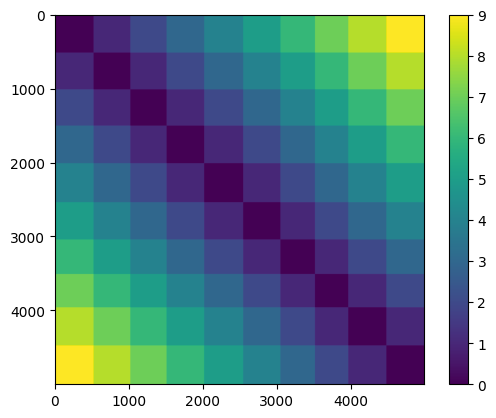

In [6]:
plt.imshow(Dy)
plt.colorbar()
plt.show()

In [7]:
X_train.shape

(55000, 28, 28, 1)

In [8]:
y_train.shape

(55000,)

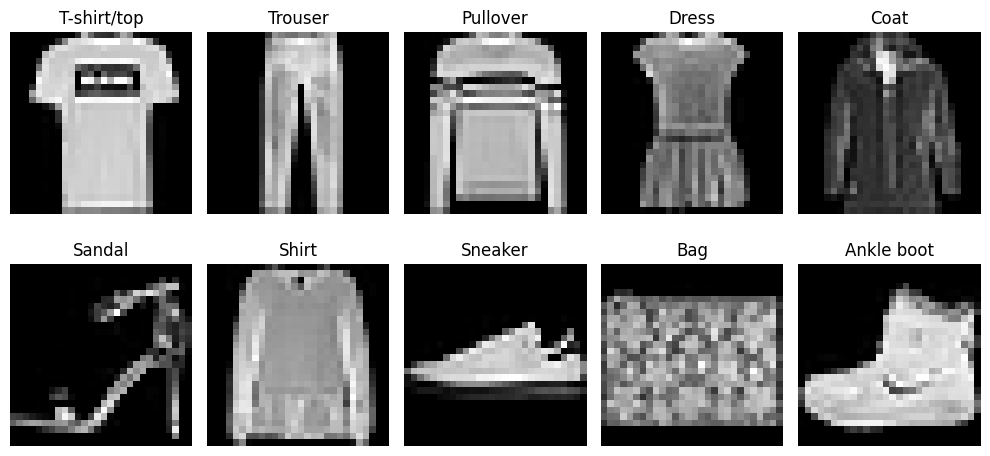

In [9]:
plt.figure(figsize=(10, 5))

# Etiquetas 
categories = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
              'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


for i in range(10):
    # Encontrar el primer ejemplo de la categoría actual
    example_index = np.where(y_train == i)[0][0]
    image = X_train[example_index]
    
    # Configurar un subgráfico para cada categoría
    plt.subplot(2, 5, i + 1)  # 2 filas, 5 columnas
    plt.imshow(image, cmap='gray')
    plt.title(categories[i])
    plt.axis('off') 

plt.tight_layout()
plt.show()

Las etiquetas de la base de datos Mnist Fashion

# Funciones

In [10]:
@tf.keras.utils.register_keras_serializable()
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [11]:
def plot_mnist_autoencoder(x, x_, y=None, y_=None, cmap='gray', vmin=0, vmax=1):
    """
    Plot the original and reconstructed MNIST images using an autoencoder, including labels.
    
    Parameters:
    ----------
    x : Sequence[np.ndarray]
        Original images.
    x_ : Sequence[np.ndarray]
        Reconstructed images.
    y : Optional[Sequence], optional
        True labels of the images, by default None.
    y_ : Optional[Sequence], optional
        Predicted labels of the images, by default None.
    cmap : str, optional
        Color map for the images, by default 'gray'.
    vmin : float, optional
        Minimum value for normalization, by default 0.
    vmax : float, optional
        Maximum value for normalization, by default 1.
    """
    plt.figure(figsize=(20, 4))
    num_images = len(x)
    
    for i in range(num_images):
        # Display original image
        plt.subplot(2, num_images, i + 1)
        plt.imshow(x[i].reshape(28, 28), cmap=cmap, vmin=vmin, vmax=vmax)
        if y is not None:
            plt.title(f'True: {y[i]}')
        plt.axis('off')
        
        # Display reconstructed image
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(x_[i].reshape(28, 28), cmap=cmap, vmin=vmin, vmax=vmax)
        if y_ is not None:
            color = "red" if y is not None and y[i] != y_[i] else 'green'
            plt.title(f'Pred: {y_[i]}', color=color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [12]:
def compare_images(original_images, predicted_images, true_labels, label_names, indices, figsize=(10, 5)):
    """
    Función para comparar visualmente imágenes originales con las predicciones, mostrando también las etiquetas verdaderas.
    Args:
    original_images (numpy.array): Array de imágenes originales.
    predicted_images (numpy.array): Array de imágenes reconstruidas por el modelo, con la forma (n_samples, height, width, channels).
    true_labels (numpy.array): Array de etiquetas verdaderas para las imágenes originales.
    label_names (list): Lista de nombres de etiquetas correspondientes a las clases.
    indices (list of int): Lista de índices de las imágenes a comparar.
    figsize (tuple): Tamaño de la figura de matplotlib.
    """
    plt.figure(figsize=figsize)
    num_images = len(indices)

    for i, index in enumerate(indices):
        # Mostrar imagen original
        plt.subplot(2, num_images, i + 1)
        plt.imshow(original_images[index].squeeze(), cmap='gray')
        plt.title(f'Original {index}\nLabel: {label_names[true_labels[index]]}')
        plt.axis('off')

        # Mostrar imagen predicha
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(predicted_images[index].squeeze(), cmap='gray')
        plt.title(f'Reconstrucción {index}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

**Definición 1** (Gretton et al., 2012a). Sea $$ ( k : \mathcal{X} \times \mathcal{X} \to \mathbb{R} )$$ el kernel de un espacio de Hilbert con núcleo reproducible $$(\mathcal{H}_k)$$, con mapas de características $$( k(\cdot, x) \in \mathcal{H}_k )$$. Sean $$( X, X' \sim \mathbb{P} )$$ y $$( Y, Y' \sim \mathbb{Q} )$$, y definimos las embeddings medias del kernel como $$( \mu_\mathbb{P} := \mathbb{E}[k(\cdot, X)] )$$ y $$( \mu_\mathbb{Q} := \mathbb{E}[k(\cdot, Y)] )$$. Bajo condiciones de integrabilidad suaves,

$$
\text{MMD}(\mathbb{P}, \mathbb{Q}; \mathcal{H}_k) := \sup_{f \in \mathcal{H}_k, |f|_{\mathcal{H}_k} \leq 1} \left|\mathbb{E}[f(X)] - \mathbb{E}[f(Y)]\right|
$$

$$
= \|\mu_\mathbb{P} - \mu_\mathbb{Q}|_{\mathcal{H}_k} = \sqrt{\mathbb{E}[k(X, X')] + \mathbb{E}[k(Y, Y')] - 2\mathbb{E}[k(X, Y)]}.
$$

Para kernels característicos, \( \mu_\mathbb{P} = \mu_\mathbb{Q} \) implica que \( \mathbb{P} = \mathbb{Q} \), por lo tanto,

$$
\text{MMD}(\mathbb{P}, \mathbb{Q}; \mathcal{H}_k) = 0 \text{ si y solo si } \mathbb{P} = \mathbb{Q}.
$$



In [13]:
def mmd_loss(y_true, y_pred):
    """
    Calcula la pérdida MMD entre y_true y y_pred.

    y_true: etiquetas verdaderas (one-hot vectors)
    y_pred: etiquetas predichas (probabilidades softmax)
    """
    # Asegurarse de que y_true y y_pred son tensores de tipo float32
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # Definir el kernel Gaussiano
    def gaussian_kernel_matrix(x, y, sigma=1):
        x_size = tf.shape(x)[0]
        y_size = tf.shape(y)[0]
        dim = tf.shape(x)[1]
        x = tf.reshape(x, [x_size, 1, dim])
        y = tf.reshape(y, [1, y_size, dim])
        kernel = tf.exp(-tf.reduce_sum(tf.square(x - y), axis=2) / (2 * sigma ** 2))
        return kernel

    # Calcular las matrices de kernel
    K_yy = gaussian_kernel_matrix(y_true, y_true)
    K_ff = gaussian_kernel_matrix(y_pred, y_pred)
    K_yf = gaussian_kernel_matrix(y_true, y_pred)

#     # Calcular la MMD
    mmd = tf.reduce_mean((K_yy) + (K_ff) - 2 * (K_yf))

    return mmd

# Funciones de pérdida
def reconstruction_loss(inputs, outputs):
    return tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.keras.backend.flatten(inputs), tf.keras.backend.flatten(outputs)))

def dkl_loss(inputs, outputs):
    z_mean, z_log_var = outputs[..., 0], outputs[..., 1]
    return - tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))



# Modelo

En mi modelo, se combina la arquitectura de LeNet-5 con un VAE (Variational Autoencoder). LeNet-5 es una red neuronal con 5 capas, de las cuales 3 son convolucionales, diseñada específicamente para la clasificación de imágenes de baja resolución y con un conjunto de datos relativamente pequeño. Esta red es eficaz para evitar el sobreentrenamiento debido a su menor profundidad en comparación con otras arquitecturas más complejas.

He incorporado elementos de un VAE en la parte de reducción de dimensión de LeNet-5, añadiendo un espacio latente y un decodificador. Esto permite no solo la clasificación de imágenes, sino también la reconstrucción de las mismas y la obtención de una representación latente de los datos.

El modelo tiene tres salidas:

* Clasificación (Softmax Output): Esta salida se utiliza para la tarea de clasificación de imágenes en una de las clases predefinidas.
* Reconstrucción (Reconstruction): Esta salida permite la reconstrucción de la imagen original a partir del espacio latente, facilitando el análisis de cómo el modelo está representando la información internamente.
* Espacio Latente (Latent Space): Esta salida proporciona las variables latentes, que son útiles para entender las características subyacentes de los datos y pueden ser utilizadas para tareas adicionales como la generación de nuevas muestras.

In [14]:
# Definir el modelo
def model_class(input_shape=(28, 28, 1), num_classes=10, latent_dim=128):
    # Encoder
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.Conv2D(6, kernel_size=3, activation='selu',
                               kernel_initializer=tf.keras.initializers.GlorotUniform(seed=12),
                               padding='same', name='conv1')(inputs)
    x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = tf.keras.layers.Dropout(0.15)(x)
    x = tf.keras.layers.Conv2D(16, kernel_size=3, activation='selu',
                               kernel_initializer=tf.keras.initializers.GlorotUniform(seed=23),
                               padding='same', name='conv2')(x)
    x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = tf.keras.layers.Conv2D(120, kernel_size=3, activation='selu',
                               kernel_initializer=tf.keras.initializers.GlorotUniform(seed=52),
                               padding='same', name='conv3')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(0.15)(x)

    z_mean = tf.keras.layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = tf.keras.layers.Dense(latent_dim, name='z_log_var')(x)
    z_gaussian = tf.keras.layers.Concatenate(name='z_gaussian', axis=-1)([z_mean, z_log_var])
    z = Sampling()([z_mean, z_log_var])
    softmax_output = tf.keras.layers.Dense(num_classes, activation='softmax', name='softmax_output')(z)

    # Decoder
    x = tf.keras.layers.Dense(7 * 7 * 16, activation='selu')(z)
    x = tf.keras.layers.Reshape((7, 7, 16))(x)
    x = tf.keras.layers.Conv2DTranspose(16, kernel_size=3, activation='selu',
                                        kernel_initializer=tf.keras.initializers.GlorotUniform(seed=12),
                                        padding='same')(x)
    x = tf.keras.layers.Dropout(0.15)(x)
    x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    x = tf.keras.layers.Conv2DTranspose(6, kernel_size=3, activation='selu',
                                        kernel_initializer=tf.keras.initializers.GlorotUniform(seed=23),
                                        padding='same', name='conv2Transpose')(x)
    x = tf.keras.layers.Dropout(0.15)(x)
    x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    reconstruction = tf.keras.layers.Conv2D(input_shape[2], kernel_size=3, padding='same',
                                            activation='sigmoid', name='reconstruction')(x)

    # VAE Model
    vae = tf.keras.models.Model(inputs, [reconstruction, z_gaussian, softmax_output], name='vae')
    return vae

# Construir y compilar el modelo
input_shape = (28, 28, 1)
num_classes = 10
latent_dim = 64
learning_rate = 1e-3

model = model_class(input_shape, num_classes, latent_dim)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss={'reconstruction': reconstruction_loss,
                    'z_gaussian': dkl_loss,
                    'softmax_output': mmd_loss},
              loss_weights={'reconstruction': 0.5,
                            'z_gaussian': 0.1,
                            'softmax_output': 0.4},
              metrics={'reconstruction': [reconstruction_loss],
                       'z_gaussian': [dkl_loss],
                       'softmax_output': [mmd_loss]}
             )

En el modelo, utilice la función de activación **SELU** Garantiza una auto-normalización para modelos secuenciales.

$
SELU_\alpha(x) = \lambda\left\{\begin{split} \alpha(\exp(x)-1)& \quad if \quad & x < 0 \\
x & \quad if \quad & x \geq 0 \\
\end{split}\right.
$

# Hiperparametros

Como hiperparametros del modelo, utilice una semilla, 100 epocas, (una epoca es el ciclo completo en el que el algoritmo de aprendizaje automático pasa por todo el conjunto de datos de entrenamiento una ve) para evaluar como cambiaban las metricas del rendimiento de mi modelo, atraves del tiempo. 

Como batch_size, probé 32,64,128, esto signific que el conjunto de datos de entrenamiento se dividirá en batches de 32 muestras cada uno, y los pesos se actualizarán después de cada batch, en mi caso a mi modelo le favorecio el tamaño de 64.
Y como utilice el optimizador Adam,que calcula adaptativamente las tasas de aprendizaje individuales para cada parámetro del modelo utilizando tanto la primera (media) como la segunda (varianza) de los momentos de los gradientes. La tasa de aprendizaje por defecto que utiliza es 1e-3:

* Tasa de Aprendizaje $(\alpha))$: Controla el tamaño del paso de actualización. Un valor típico es 0.001.
* $(\beta_1)$: Tasa de decaimiento exponencial para el primer momento. Típicamente se usa 0.9.
* $(\beta_2)$: Tasa de decaimiento exponencial para el segundo momento. Típicamente se usa 0.999.
* $(\epsilon)$: Término de estabilidad numérica para evitar divisiones por cero, comúnmente $(10^{-8})$

In [15]:
seed = 42
epochs = 120
batch_size = 64
learning_rate =1e-3

# Entrenamiento

In [16]:
history = model.fit(X_train,
                    [X_train, X_train, y_train_one_hot],
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_valid, [X_valid, X_valid, y_valid_one_hot])
                   )

Epoch 1/120


I0000 00:00:1727902024.332456     150 service.cc:145] XLA service 0x7c1640007460 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727902024.332504     150 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1727902024.332509     150 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 35/860 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.3746 - reconstruction_reconstruction_loss: 0.5972 - softmax_output_mmd_loss: 0.1214 - z_gaussian_dkl_loss: 0.2740 

I0000 00:00:1727902034.349222     150 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


860/860 ━━━━━━━━━━━━━━━━━━━━ 31s 20ms/step - loss: 0.2036 - reconstruction_reconstruction_loss: 0.3645 - softmax_output_mmd_loss: 0.0446 - z_gaussian_dkl_loss: 0.0352 - val_loss: 0.1552 - val_reconstruction_reconstruction_loss: 0.2883 - val_softmax_output_mmd_loss: 0.0276 - val_z_gaussian_dkl_loss: 0.0010
Epoch 2/120
860/860 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1569 - reconstruction_reconstruction_loss: 0.2938 - softmax_output_mmd_loss: 0.0241 - z_gaussian_dkl_loss: 0.0037 - val_loss: 0.1489 - val_reconstruction_reconstruction_loss: 0.2821 - val_softmax_output_mmd_loss: 0.0194 - val_z_gaussian_dkl_loss: 4.4826e-04
Epoch 3/120
860/860 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1514 - reconstruction_reconstruction_loss: 0.2877 - softmax_output_mmd_loss: 0.0185 - z_gaussian_dkl_loss: 0.0015 - val_loss: 0.1467 - val_reconstruction_reconstruction_loss: 0.2773 - val_softmax_output_mmd_loss: 0.0202 - val_z_gaussian_dkl_loss: 5.4963e-04
Epoch 4/120
860/860 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/ste

# Loss sin normalizar 

**Funciones de pérdida:**

La pérdida de reconstrucción asegura que el modelo pueda reconstruir las imágenes de entrada con precisión, utilice entropía cruzada binaria es adecuada para la comparación de imágenes píxel por píxel, especialmente cuando los píxeles pueden tener valores binarios (0 o 1) o valores continuos entre 0 y 1 (como en imágenes normalizadas).

La pérdida de divergencia Kullback-Leibler regula el espacio latente, manteniendo su distribución cerca de una normal estándar, lo cual es crucial para la generación de nuevas muestras. La divergencia Kullback-Leibler (DKL) mide la diferencia entre la distribución aprendida por el modelo (parametrizada por z_mean y z_log_var) y una distribución normal estándar. Esta regularización es crucial para la generación de nuevas muestras y para mantener la consistencia en el espacio latente.

La pérdida de clasificación optimiza la capacidad del modelo para clasificar correctamente las imágenes en diferentes categorías, la entropía cruzada categórica dispersa es adecuada para tareas de clasificación multi-clase donde las etiquetas son enteros. Evalúa la discrepancia entre las etiquetas verdaderas y las probabilidades predichas por el modelo.

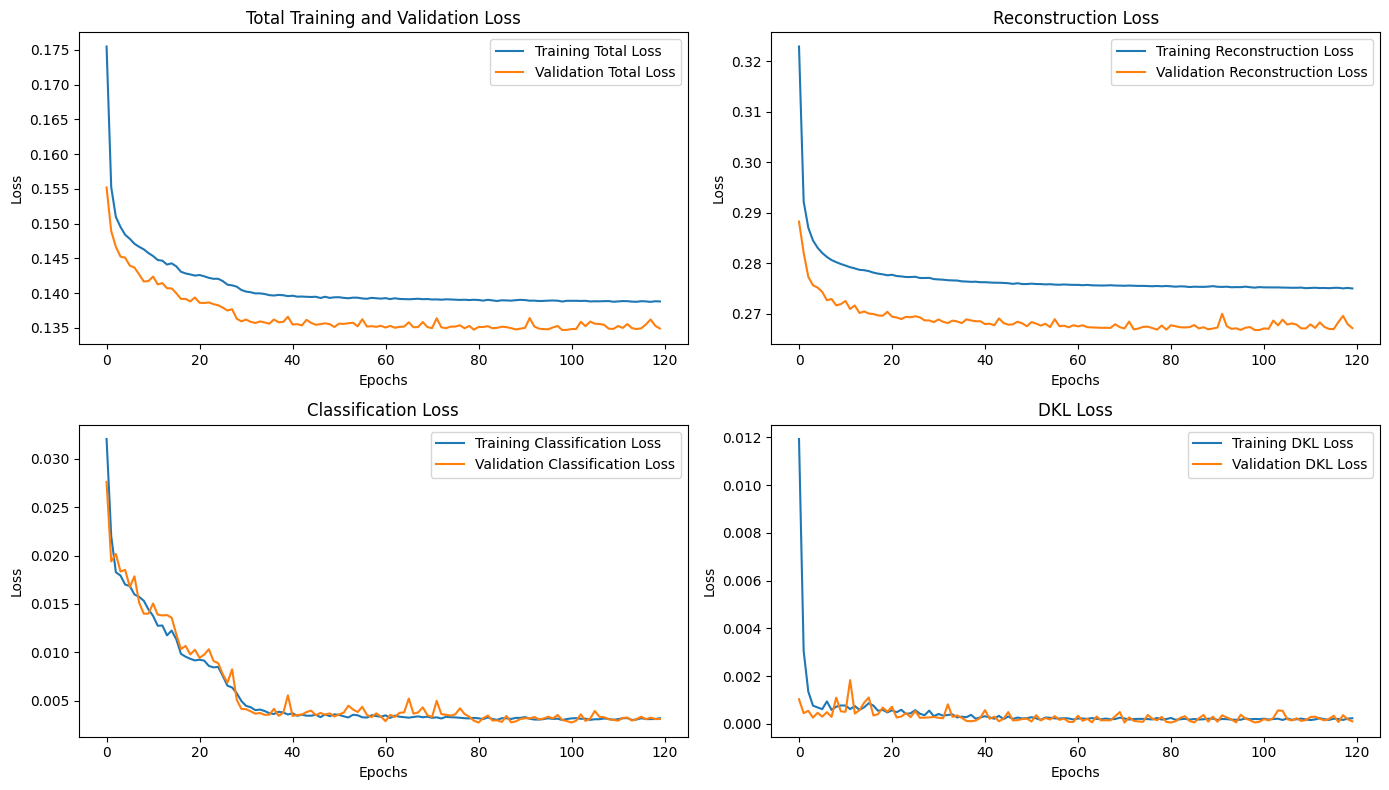

In [17]:
loss = history.history['loss']
val_loss = history.history['val_loss']
reconstruction_loss = history.history['reconstruction_reconstruction_loss']
val_reconstruction_loss = history.history['val_reconstruction_reconstruction_loss']
classification_loss = history.history['softmax_output_mmd_loss']
val_classification_loss = history.history['val_softmax_output_mmd_loss']
dkl_loss = history.history['z_gaussian_dkl_loss']
val_dkl_loss = history.history['val_z_gaussian_dkl_loss']

plt.figure(figsize=(14, 8))

# Gráfico para la pérdida total
plt.subplot(2, 2, 1)
plt.plot(loss, label='Training Total Loss')
plt.plot(val_loss, label='Validation Total Loss')
plt.title('Total Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Gráfico para la pérdida de reconstrucción
plt.subplot(2, 2, 2)
plt.plot(reconstruction_loss, label='Training Reconstruction Loss')
plt.plot(val_reconstruction_loss, label='Validation Reconstruction Loss')
plt.title('Reconstruction Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Gráfico para la pérdida de clasificación
plt.subplot(2, 2, 3)
plt.plot(classification_loss, label='Training Classification Loss')
plt.plot(val_classification_loss, label='Validation Classification Loss')
plt.title('Classification Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Gráfico para la pérdida DKL
plt.subplot(2, 2, 4)
plt.plot(dkl_loss, label='Training DKL Loss')
plt.plot(val_dkl_loss, label='Validation DKL Loss')
plt.title('DKL Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Mostrar los gráficos
plt.tight_layout()
plt.show()

En las graficas de las pérdidas se puede observar que:

* **Pérdida Total (Total Training and Validation Loss)**: Este gráfico muestra que tanto la pérdida total de entrenamiento como de validación disminuyen de manera significativa al principio y luego se estabilizan, lo cual es un buen indicador de que el modelo está aprendiendo adecuadamente sin signos evidentes de sobreajuste, ya que las líneas de entrenamiento y validación siguen patrones similares.

* **Pérdida de Reconstrucción (Reconstruction Loss)**: Se observa que la pérdida de reconstrucción, tanto en entrenamiento como en validación, disminuye de manera constante. Esto sugiere que el modelo está mejorando su capacidad para reconstruir los datos de entrada, lo cual es especialmente relevante en modelos como autoencoders.

* ** Pérdida de Clasificación (Classification Loss)**: La pérdida de clasificación muestra picos esporádicos, especialmente en la fase de validación, lo que podría indicar problemas de estabilidad en el aprendizaje para la tarea de clasificación. Esto podría ser un área para revisar, tal vez ajustando hiperparámetros o revisando el balance de clases en los datos.

* **Pérdida de Divergencia Kullback-Leibler (DKL Loss)**: Este gráfico muestra fluctuaciones en la pérdida de divergencia KL, que mide qué tan bien la distribución de probabilidad aprendida por el modelo se aproxima a la distribución real de los datos. Las fluctuaciones aquí podrían ser normales, pero si son muy pronunciadas o si el modelo no mejora, podrían necesitarse ajustes.

In [18]:
X_re = model.predict(X_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step


In [19]:
len(X_re)

3

# *Reconstrucción*

In [20]:
X_re[0].shape

(10000, 28, 28, 1)

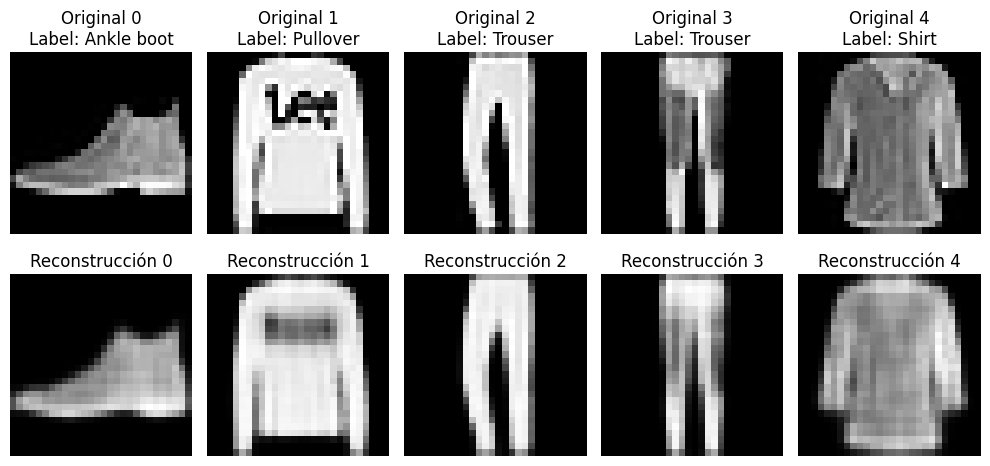

In [21]:
num_samples = 5 
indices_to_compare = [i for i in range(num_samples)] 

# Nombres de etiquetas para el dataset Fashion MNIST
label_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

compare_images(X_test, X_re[0], y_test, label_names, indices_to_compare)


La gráfica demuestra que el modelo es capaz de reconstruir imágenes de ropa de manera razonable, preservando la forma general y la clase de los objetos.

# *Espacio latente*

In [22]:
z=X_re[1].reshape(X_re[1].shape[0],-1)

In [23]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(z)
tsne = TSNE(n_components=2, perplexity= 50)
z_tsne =  MinMaxScaler().fit_transform(tsne.fit_transform(scaled_data))

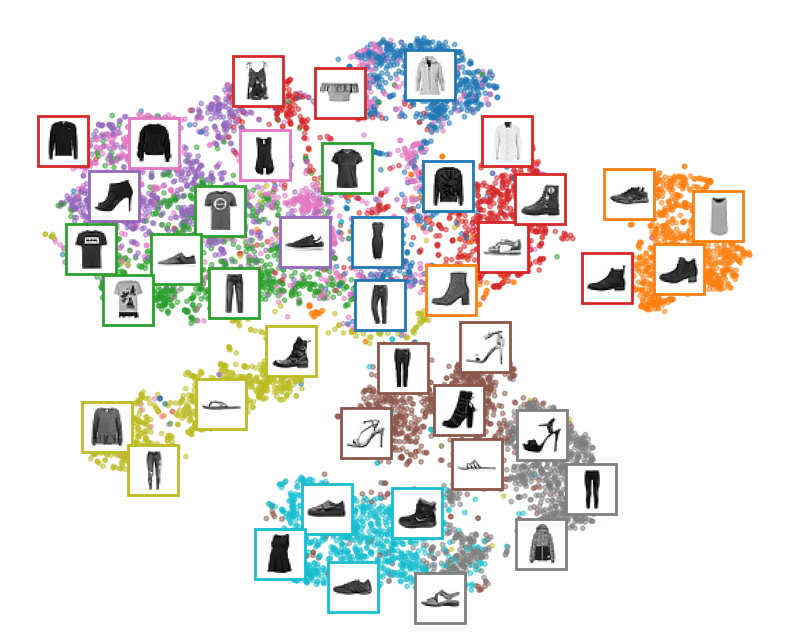

In [24]:
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10

plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c=y_test, alpha=0.5, s=10, cmap=cmap)

# Inicializar posiciones de imágenes
image_positions = np.array([[1., 1.]])

# Iterar sobre las posiciones y añadir imágenes
for index, position in enumerate(z_tsne):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.01:  # si está suficientemente lejos de otras imágenes
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_train[index], cmap="binary"),  # Suponiendo que X_train contiene las imágenes originales
            position, bboxprops={"edgecolor": cmap(y_test[index]), "lw": 2})
        plt.gca().add_artist(imagebox)

# Configurar el gráfico y guardar la figura
plt.axis("off")
plt.show()

La visualización del espacio latente muestra que el modelo de VAE ha aprendido representaciones efectivas y discriminativas de las diferentes clases de ropa. Las agrupaciones claras y la separación entre las clases indican que el modelo puede capturar las características esenciales de cada clase en el espacio latente. 

# *Clasificación*

In [25]:
X_re[2].shape

(10000, 10)

In [26]:
# Obtén las predicciones de clasificación
softmax_output = X_re[2]  
predicted_labels = np.argmax(softmax_output, axis=1)

accuracy = accuracy_score(y_test, predicted_labels)
print("Accuracy:", accuracy)
print(classification_report(y_test, predicted_labels))

Accuracy: 0.8414
              precision    recall  f1-score   support

           0       0.79      0.81      0.80      1000
           1       0.99      0.95      0.97      1000
           2       0.72      0.73      0.73      1000
           3       0.84      0.87      0.85      1000
           4       0.74      0.68      0.71      1000
           5       0.97      0.94      0.95      1000
           6       0.59      0.58      0.59      1000
           7       0.92      0.94      0.93      1000
           8       0.91      0.96      0.93      1000
           9       0.95      0.95      0.95      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



En general de cada una de las clases, tiene un buen rendimiento de clasificación.

# *Reconstrucción y clasificación*

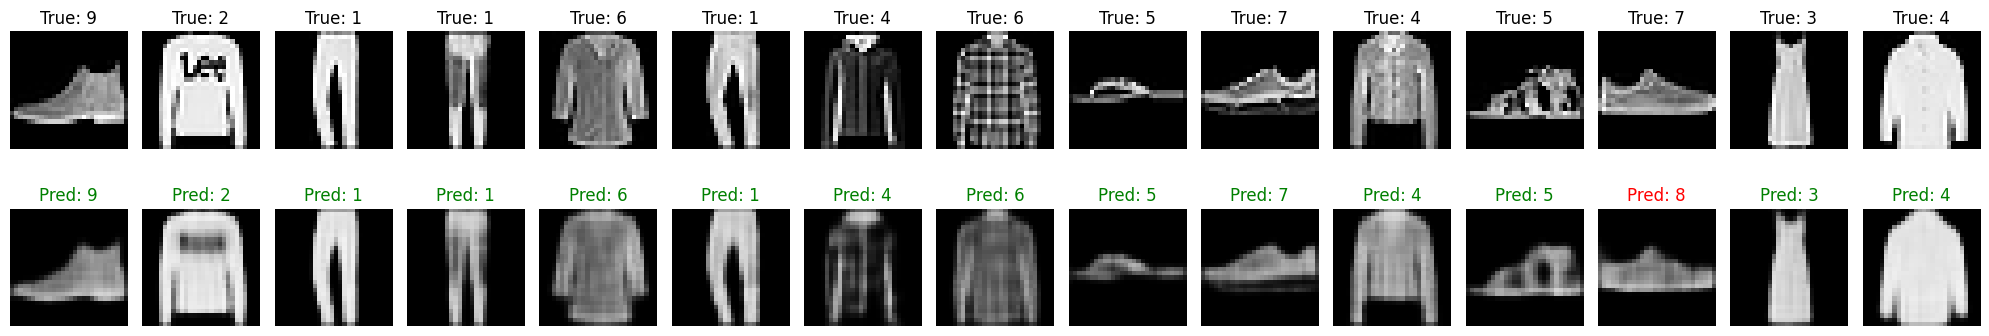

In [27]:
N = 15
predicted_labels = np.argmax(X_re[2][:N], axis=1) 
plot_mnist_autoencoder(
    X_test[:N], 
    X_re[0][:N], 
    y_test[:N],  
    predicted_labels  
)

La gráfica proporciona una visión clara del rendimiento del modelo en términos de sus predicciones correctas e incorrectas. Las predicciones correctas predominan en este primer conjunto de datos, lo que sugiere que el modelo tiene un buen rendimiento general. Sin embargo, las predicciones incorrectas resaltadas en rojo indican áreas donde el modelo puede mejorar.

# *Cams*

Los **Class Activation Maps (CAM)** son una técnica visual que se utiliza para comprender qué partes de una imagen influyen más en la clasificación realizada por una red neuronal convolucional **(CNN)**. Esta técnica ayuda a hacer más transparente y comprensible el proceso de toma de decisiones de las **CNN,** lo cual es especialmente valioso en aplicaciones donde la interpretación de los resultados es crucial, como en diagnóstico médico o en sistemas de visión para vehículos autónomos.

**Uso de Redes Neuronales Convolucionales (CNN):**
Los CAM se generan utilizando redes neuronales convolucionales que han sido entrenadas para tareas de clasificación de imágenes. Estas redes aprenden automáticamente características relevantes de las imágenes a través de sus capas convolucionales.

**Aplicabilidad de los CAM**

* **Interpretabilidad:**
Los CAM permiten visualizar qué áreas de la imagen fueron determinantes para la decisión de la red, lo que aporta transparencia y permite a los usuarios entender y verificar si el modelo está haciendo las predicciones por razones válidas.

Al identificar las regiones de la imagen que son más informativas para la clasificación, los CAM pueden ser utilizados para mejorar el entrenamiento de la red neuronal. Por ejemplo, si un modelo se centra en áreas irrelevantes para tomar decisiones, esto puede indicar problemas en los datos de entrenamiento o en la arquitectura de la red.

* **Diagnóstico Médico:**
En aplicaciones médicas, los CAM pueden ayudar a los doctores a localizar áreas anormales en imágenes médicas, como tumores en imágenes de resonancia magnética o radiografías, proporcionando una segunda opinión automatizada que complementa la evaluación del especialista.

* **Validación y Ajuste Fino:**
En aplicaciones críticas, como la conducción autónoma, los CAM pueden utilizarse para validar que la red está centrando su atención en las áreas correctas de la carretera o en objetos relevantes como peatones o señales de tráfico, y no en distracciones o ruido.



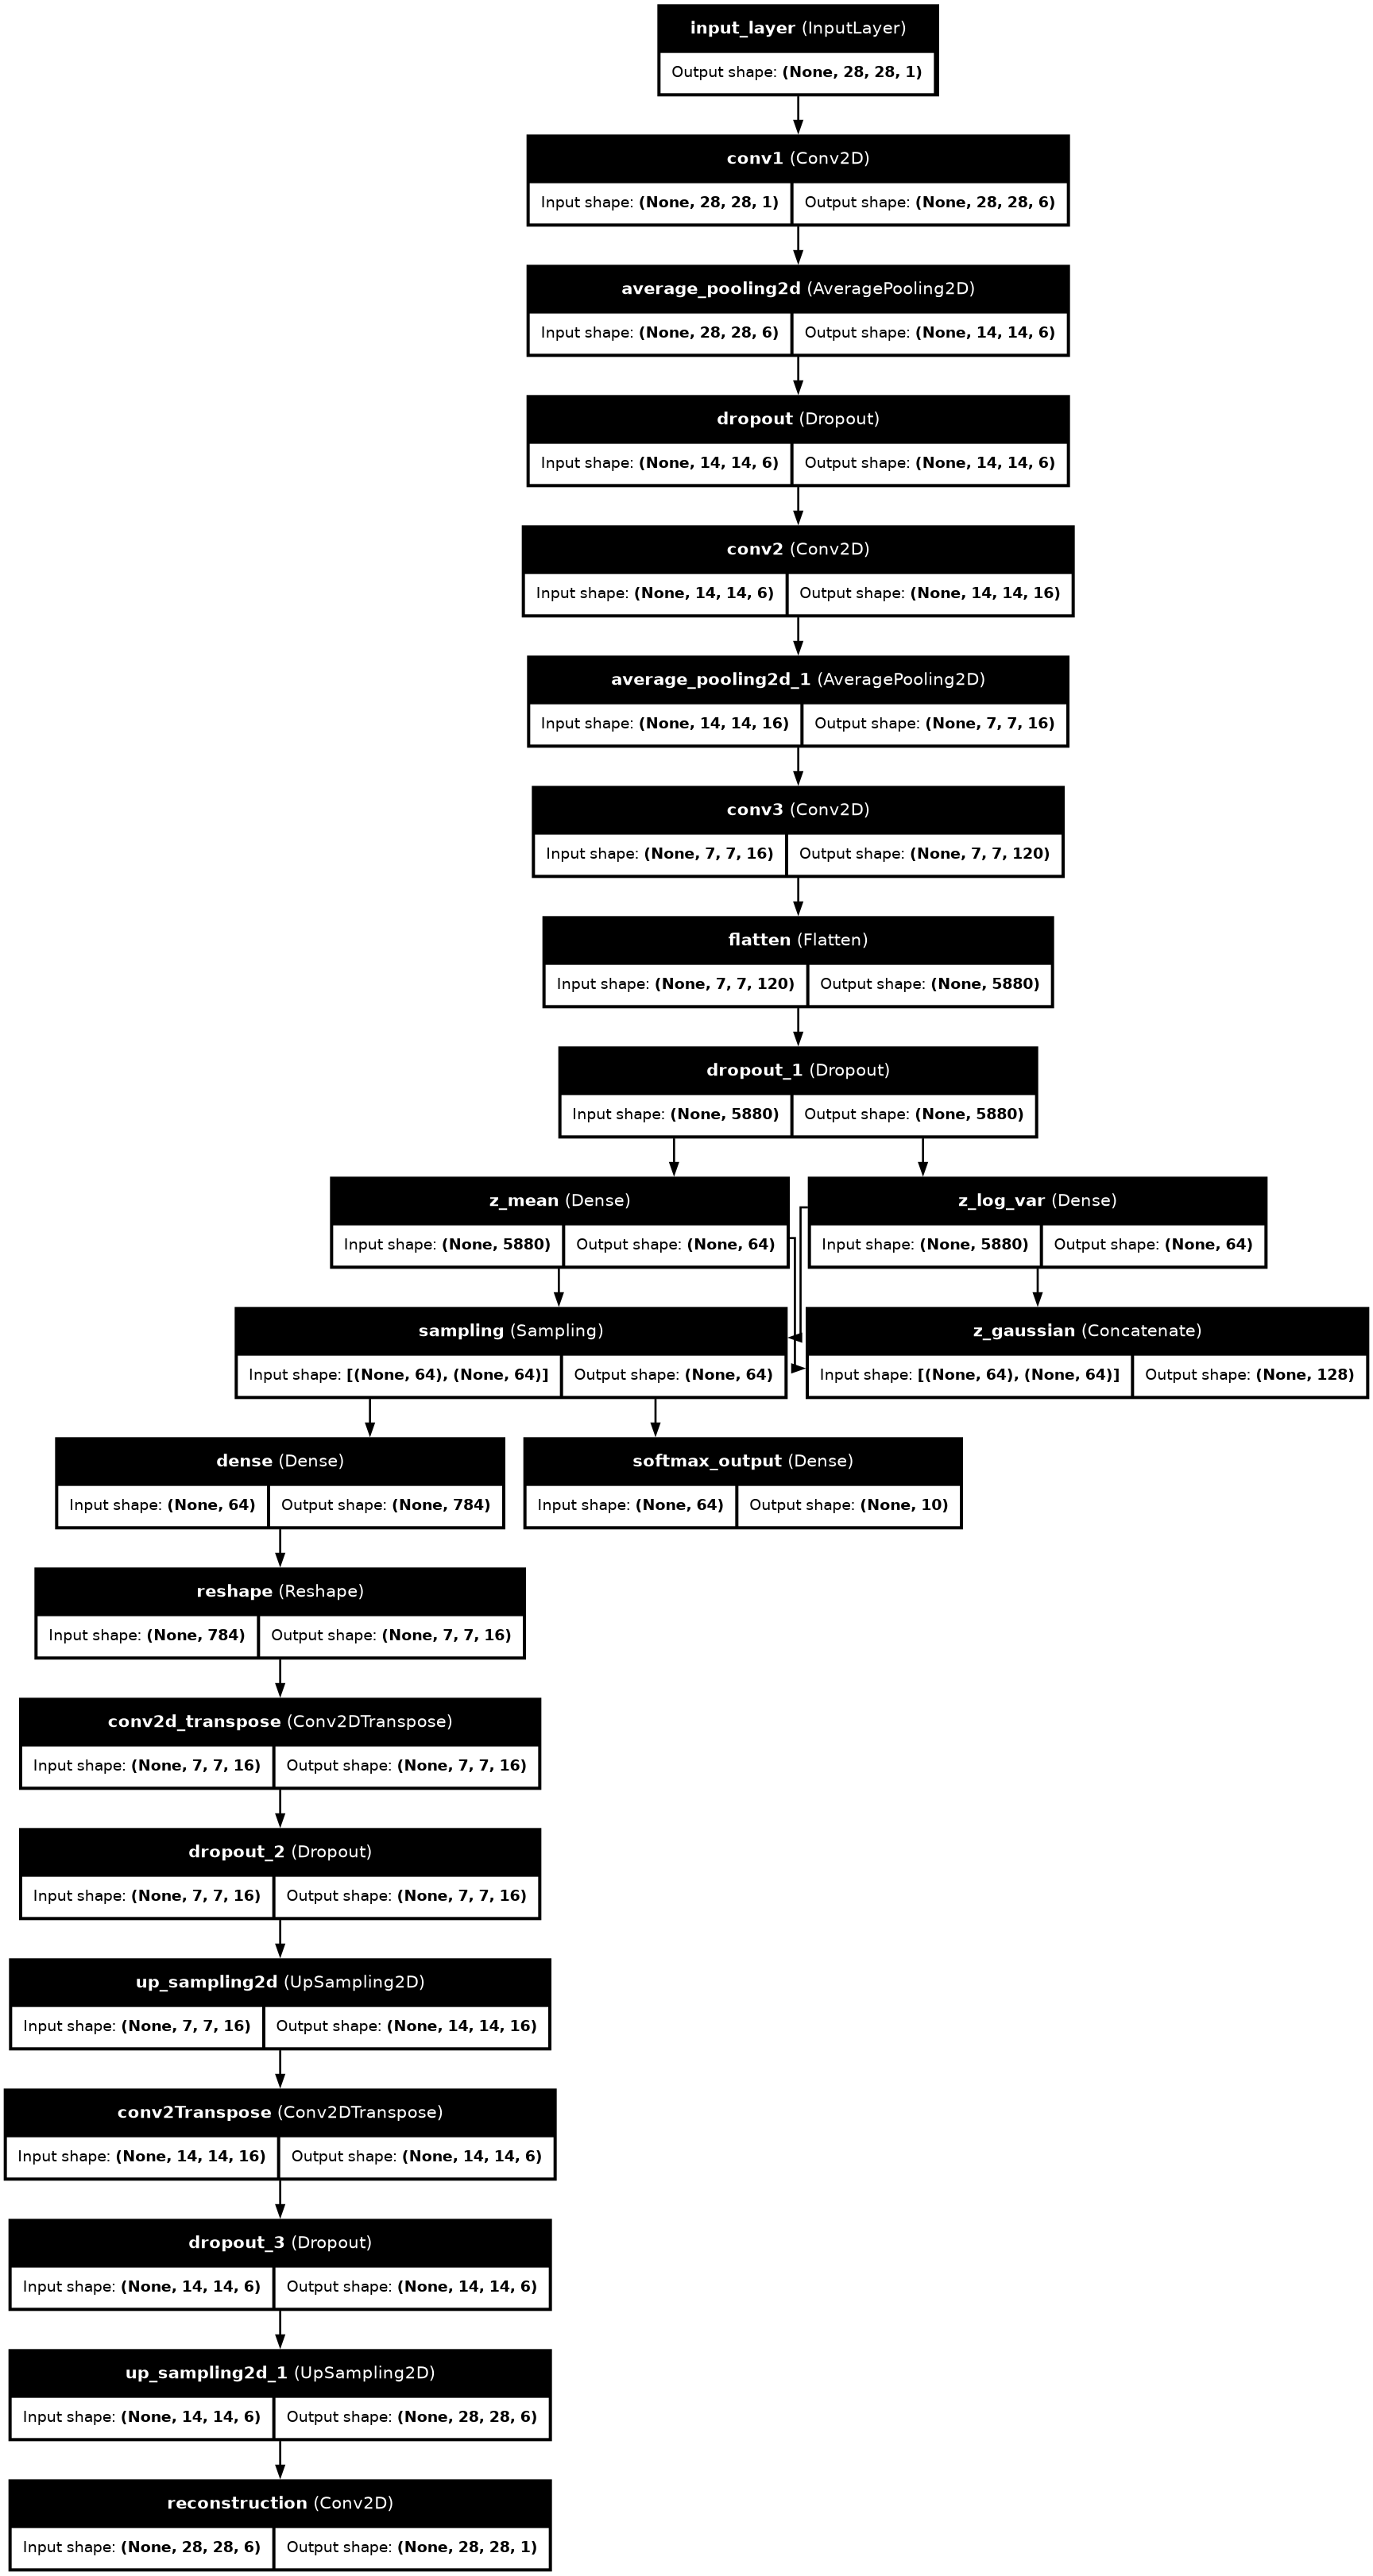

In [28]:
tf.keras.utils.plot_model(model, show_layer_names=True, show_shapes=True, dpi=96)

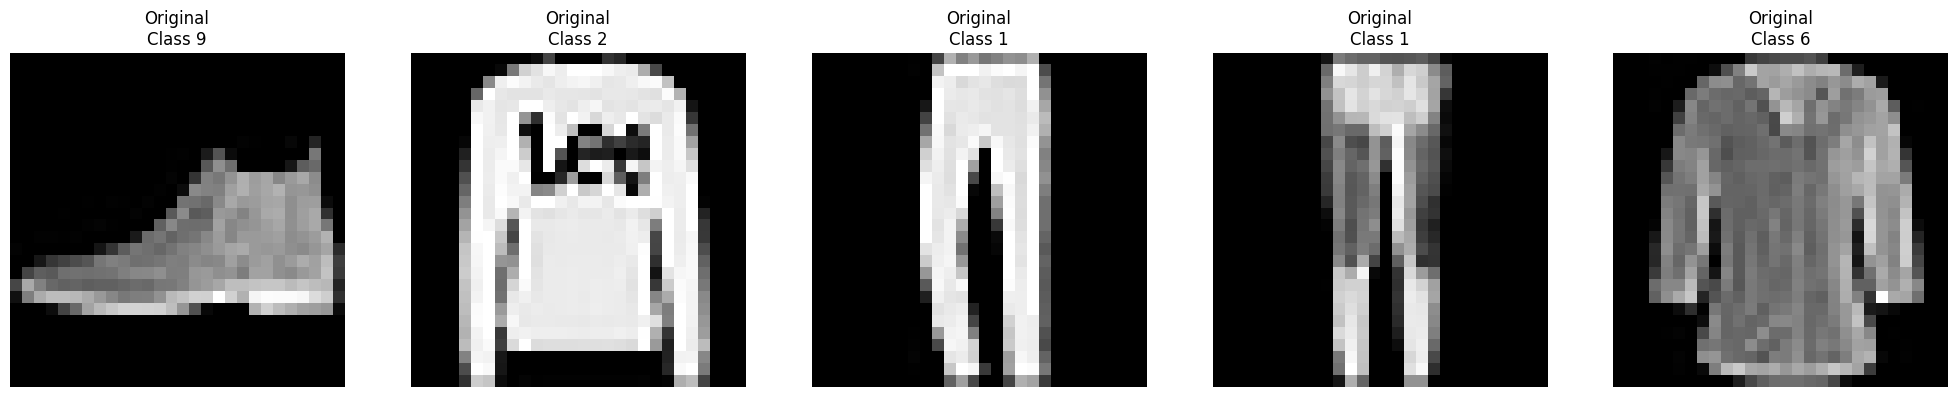

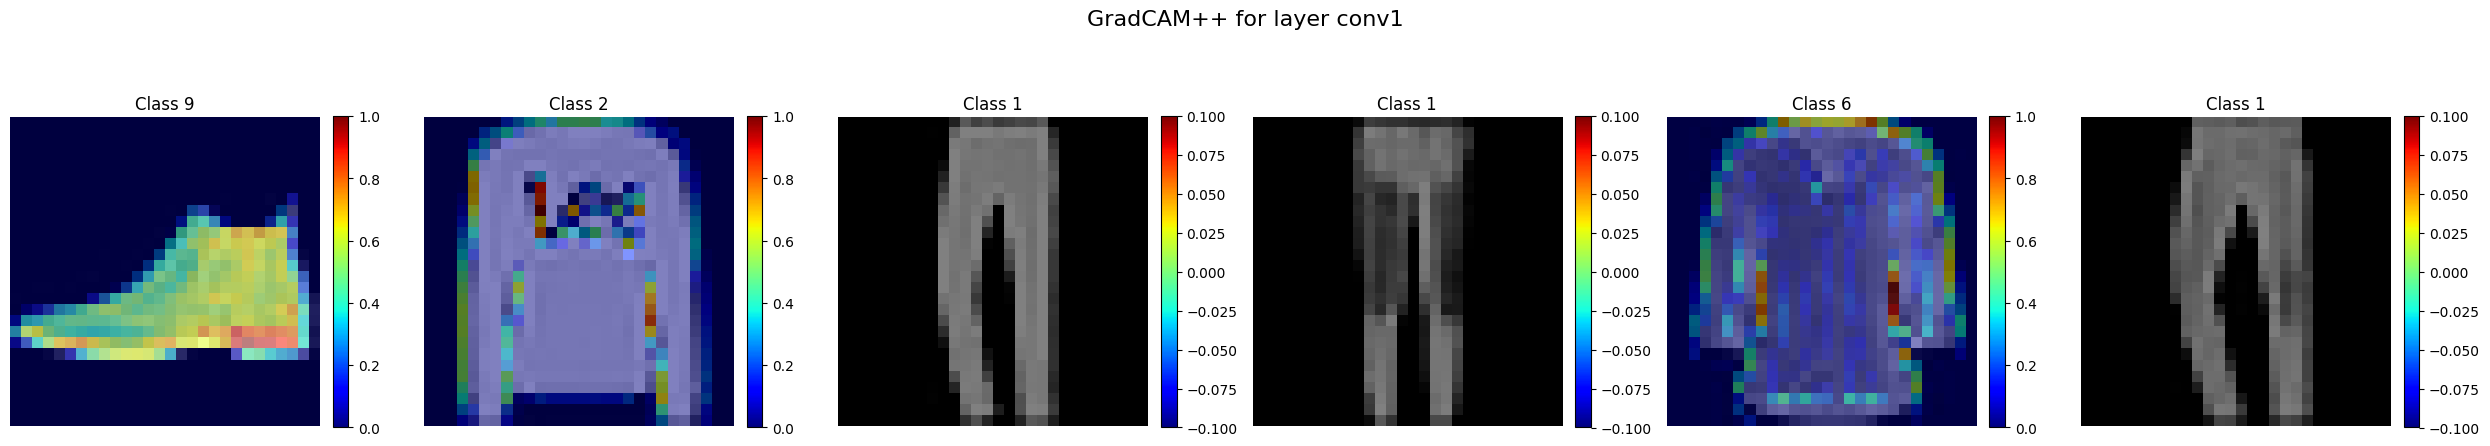

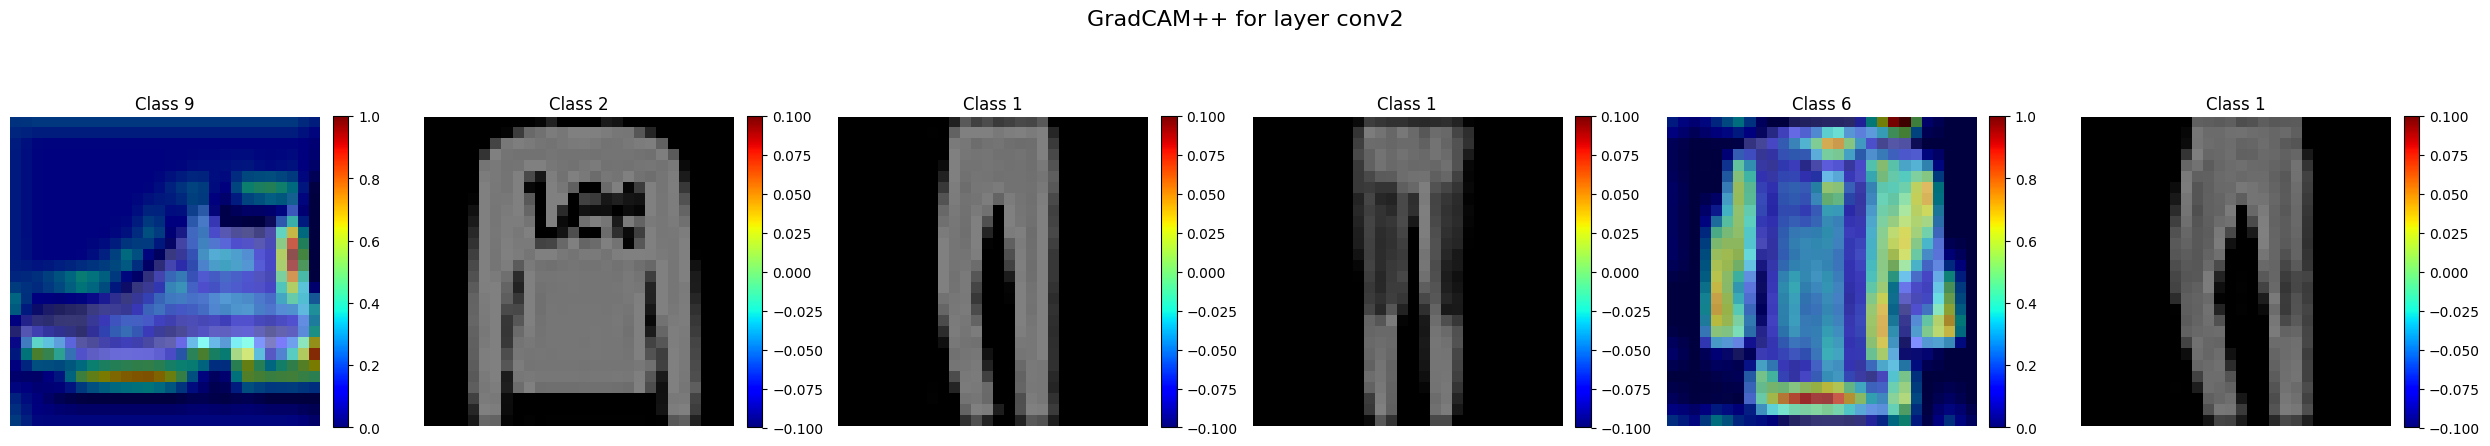

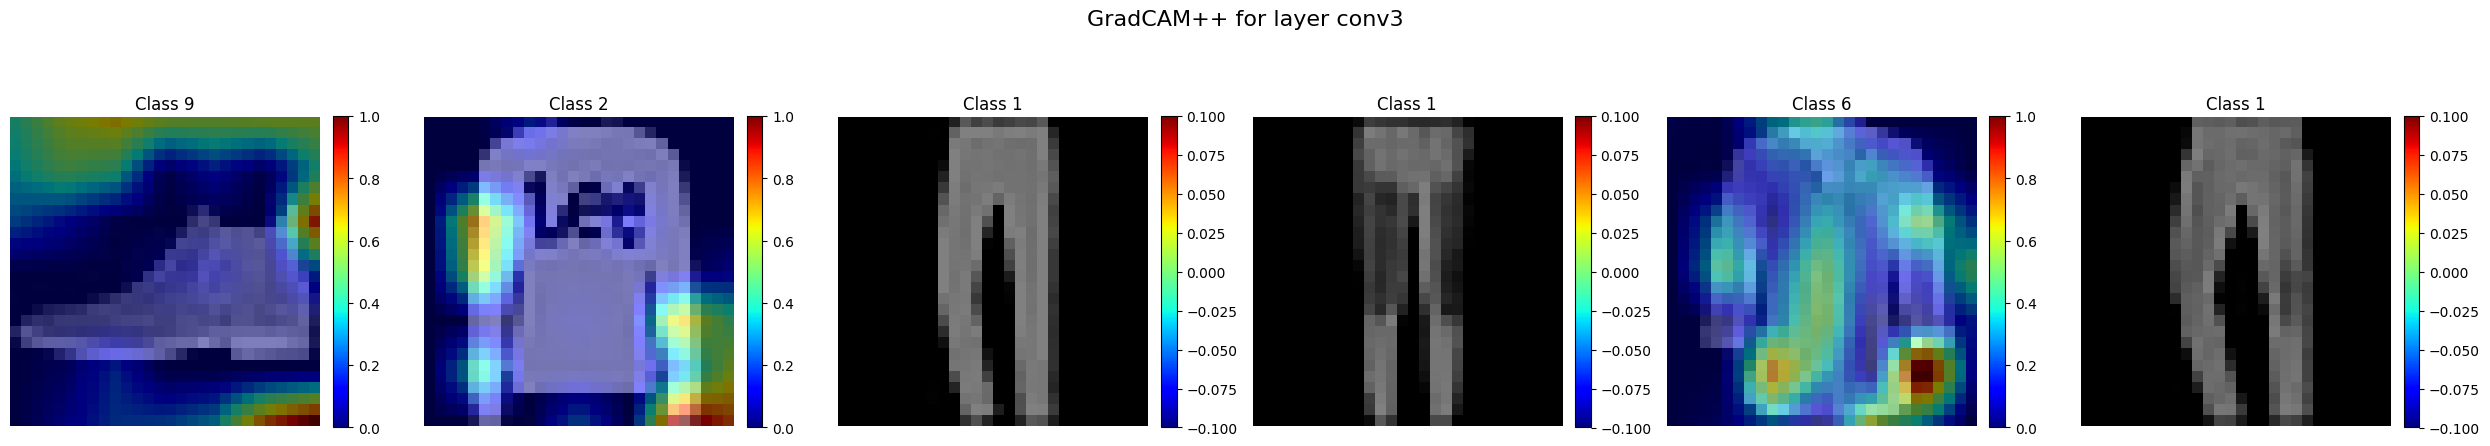

In [29]:
layers = ['conv1', 'conv2', 'conv3']

# Visualizar la imagen original con mayor tamaño
fig, axes = plt.subplots(1, 5, figsize=(25, 5))

num_images = 5
images = X_test[:num_images].reshape(-1, 28, 28, 1)
labels = y_test[:num_images]

for i in range(5):
    image = images[i]
    label = labels[i]
    ax_img = axes[i]
    ax_img.imshow(image.squeeze(), cmap='gray')
    ax_img.axis('off')
    ax_img.set_title(f'Original\nClass {label}')

for layer in layers:
    # Crear el modelo que solo tenga la salida del clasificador
    model_for_gradcam = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer('softmax_output').output)

    # Crear el objeto GradCAM++
    gradcam = GradcamPlusPlus(model_for_gradcam, model_modifier=ReplaceToLinear(), clone=True)

    # Seleccionar las primeras 6 imágenes del conjunto de prueba
    num_images = 6
    images = X_test[:num_images].reshape(-1, 28, 28, 1)
    labels = y_test[:num_images]

    # Crear una figura con subplots
    fig, axes = plt.subplots(1, 6, figsize=(25, 5))
    fig.suptitle(f'GradCAM++ for layer {layer}', fontsize=16)  # Añadir título con el nombre de la capa

    for i, (image, label) in enumerate(zip(images, labels)):
        # Generar el CAM con GradCAM++ usando la capa actual
        cam = gradcam(CategoricalScore(label), image.reshape(1, 28, 28, 1), penultimate_layer=layer)

        # Visualizar el mapa de calor superpuesto en la imagen original
        heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)
        ax_heatmap = axes[i]
        ax_heatmap.imshow(image.squeeze(), cmap='gray')
        ax_heatmap.imshow(heatmap, cmap='jet', alpha=0.5)
        ax_heatmap.axis('off')
        ax_heatmap.set_title(f'Class {label}')
        
        # Añadir la barra de colores (color bar)
        norm = plt.Normalize(vmin=cam[0].min(), vmax=cam[0].max())
        sm = plt.cm.ScalarMappable(cmap='jet', norm=norm)
        sm.set_array([])
        fig.colorbar(sm, ax=ax_heatmap, orientation="vertical", fraction=0.046, pad=0.04)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Ajustar layout para el título
    plt.show()


GradCAM++ visualiza las regiones de la imagen que más contribuyen a la decisión de clasificación del modelo.
Las áreas en rojo indican una alta activación y una fuerte contribución a la clasificación, mientras que las áreas en azul indican baja activación.
Capa conv1:

* En la primera capa convolucional **(conv1)**, las activaciones están dispersas y no claramente enfocadas en características específicas de las imágenes. Esto es esperado ya que las primeras capas suelen capturar características de bajo nivel como bordes y texturas.


* En la segunda capa convolucional **(conv2)**, las activaciones empiezan a ser más enfocadas, indicando que el modelo comienza a capturar características más complejas y relevantes para la clasificación.


* En la tercera capa convolucional **(conv3)**, las activaciones son aún más específicas y concentradas en las regiones más relevantes de las imágenes.


Comparando las activaciones de diferentes capas, se puede observar cómo el modelo refina su atención a medida que las características pasan a través de las capas convolucionales.
Las capas más profundas capturan características de alto nivel y están más alineadas con las características humanas perceptibles de las clases de ropa.

# *Clase 9*

En este caso, dicscrimine las clases para comparar como se comporta una clase, comparada con las demas clases, si se presentan activaciones cuando no es la clase que se esta evaluando.

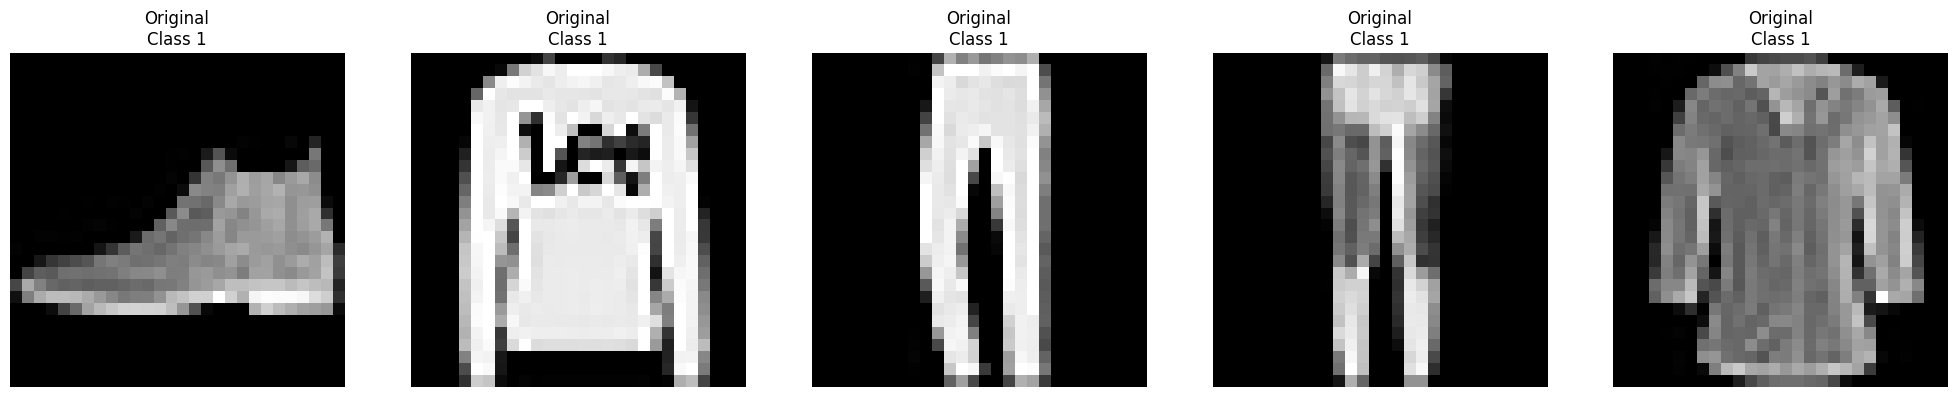

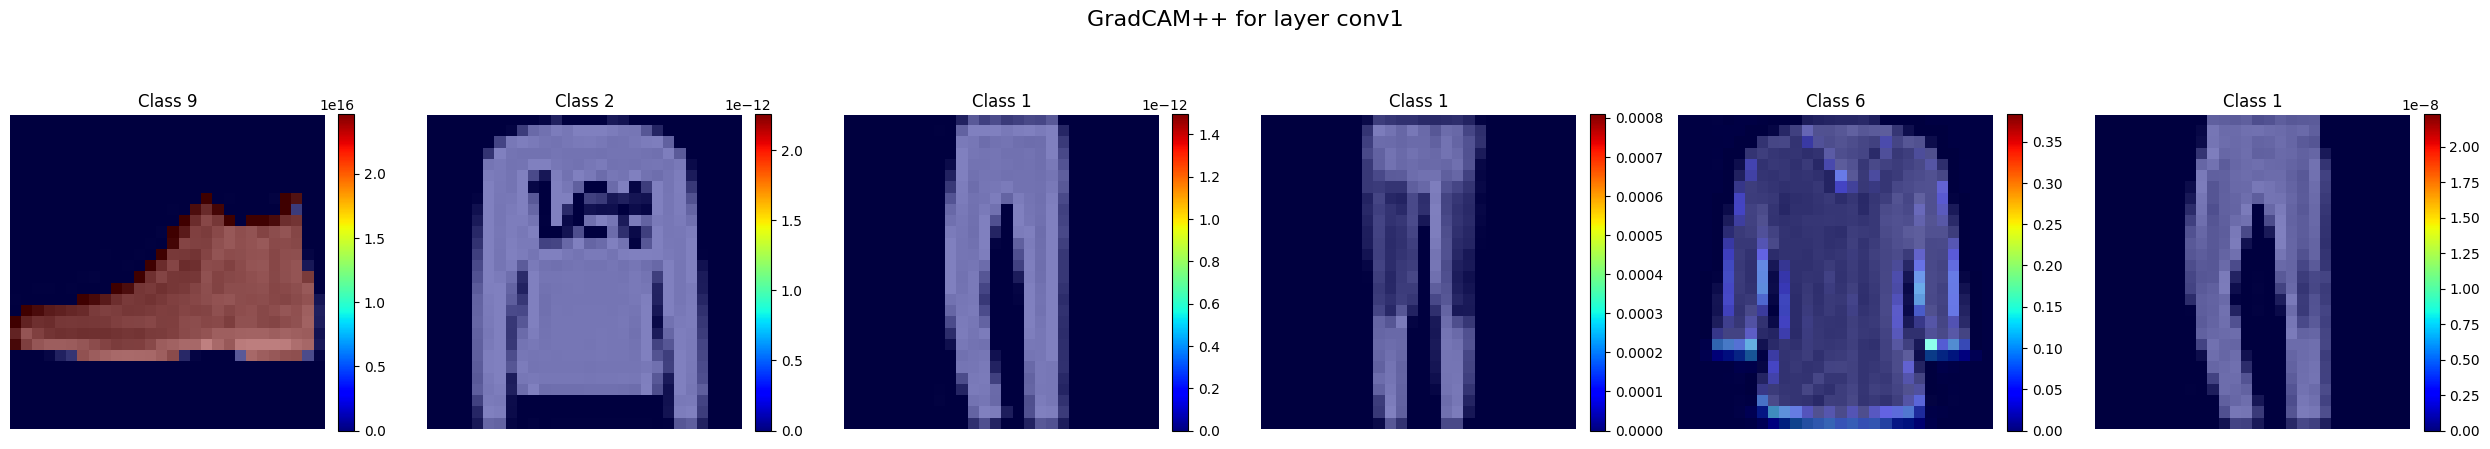

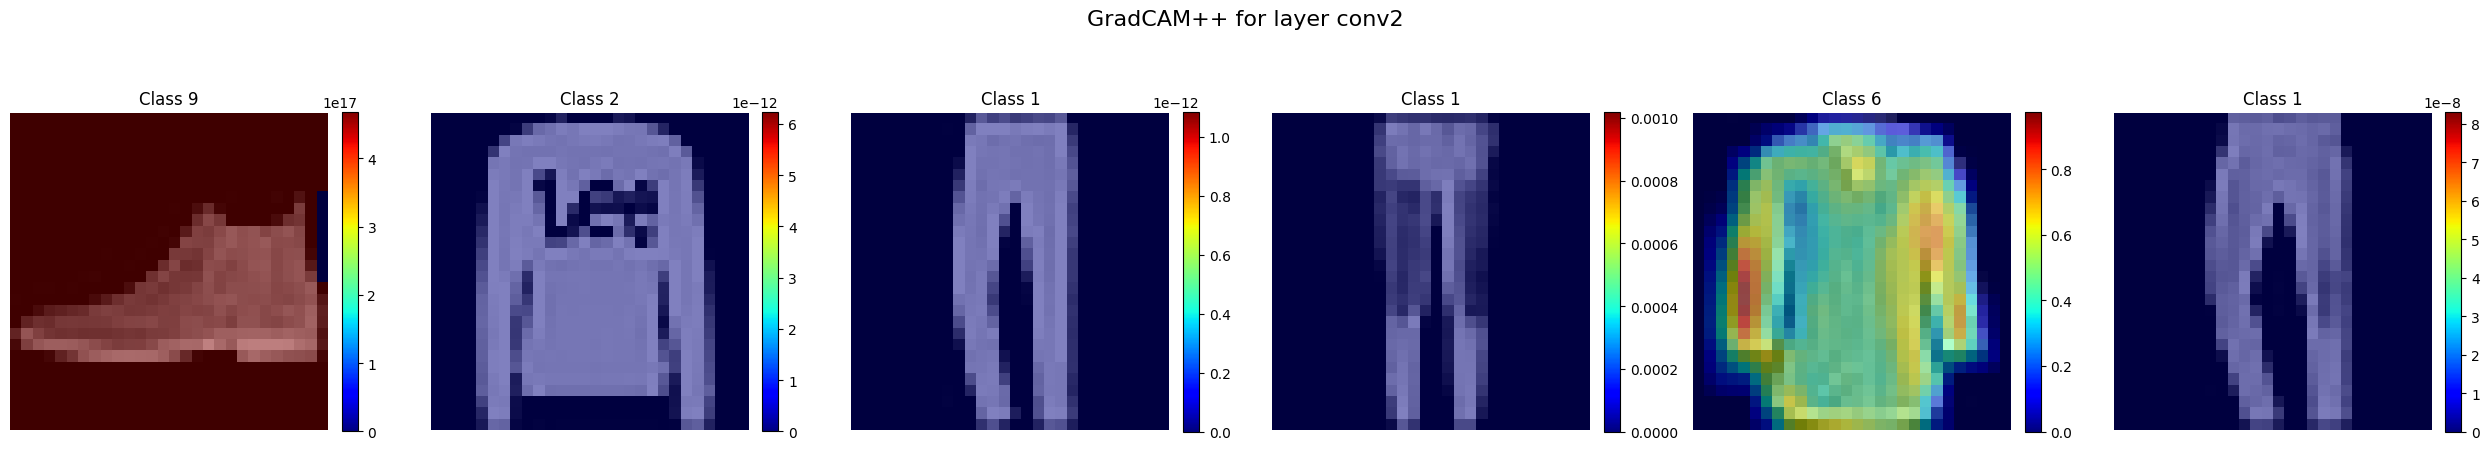

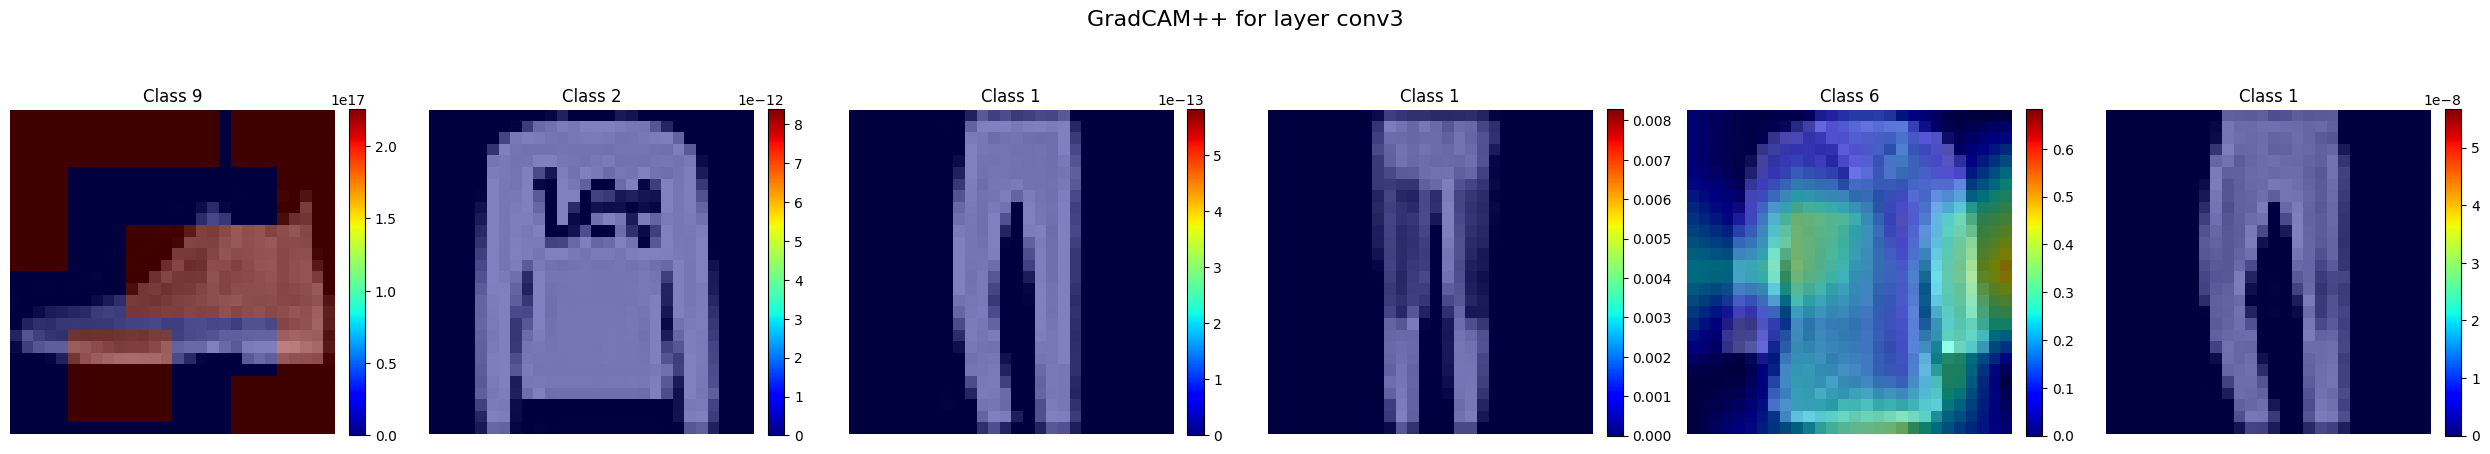

In [30]:
layers = ['conv1', 'conv2', 'conv3']

# Visualizar la imagen original con mayor tamaño
fig, axes = plt.subplots(1, 5, figsize=(25, 5))

for i in range(5):
    num_images = 5
    images = X_test[:num_images].reshape(-1, 28, 28, 1)
    image = images[i]
    ax_img = axes[i]
    ax_img.imshow(image.squeeze(), cmap='gray')
    ax_img.axis('off')
    ax_img.set_title(f'Original\nClass {label}')

for layer in layers:
    # Crear el modelo que solo tenga la salida del clasificador
    model_for_gradcam = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer('softmax_output').output)

    # Crear el objeto GradCAM++
    gradcam = GradcamPlusPlus(model_for_gradcam, model_modifier=ReplaceToLinear(), clone=True)

    # Seleccionar las primeras 6 imágenes del conjunto de prueba
    num_images = 6
    images = X_test[:num_images].reshape(-1, 28, 28, 1)
    labels = y_test[:num_images]

    # Crear una figura con subplots
    fig, axes = plt.subplots(1, 6, figsize=(25, 5))
    fig.suptitle(f'GradCAM++ for layer {layer}', fontsize=16)  # Añadir título con el nombre de la capa

    for i, (image, label) in enumerate(zip(images, labels)):
        # Generar el CAM con GradCAM++ usando la capa 'convv'
        cam = gradcam(CategoricalScore(9), image.reshape(1, 28, 28, 1), penultimate_layer=layer, normalize_cam=False)

        # Visualizar el mapa de calor superpuesto en la imagen original
        heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)
        ax_heatmap = axes[i]
        ax_heatmap.imshow(image.squeeze(), cmap='gray')
        ax_heatmap.imshow(heatmap, cmap='jet', alpha=0.5)
        ax_heatmap.axis('off')
        ax_heatmap.set_title(f'Class {label}')
        
        # Añadir la barra de colores (color bar)
        norm = plt.Normalize(vmin=cam[0].min(), vmax=cam[0].max())
        sm = plt.cm.ScalarMappable(cmap='jet', norm=norm)
        sm.set_array([])
        fig.colorbar(sm, ax=ax_heatmap, orientation="vertical", fraction=0.046, pad=0.04)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Ajustar layout para el título
    plt.show()

# *Clase 1*

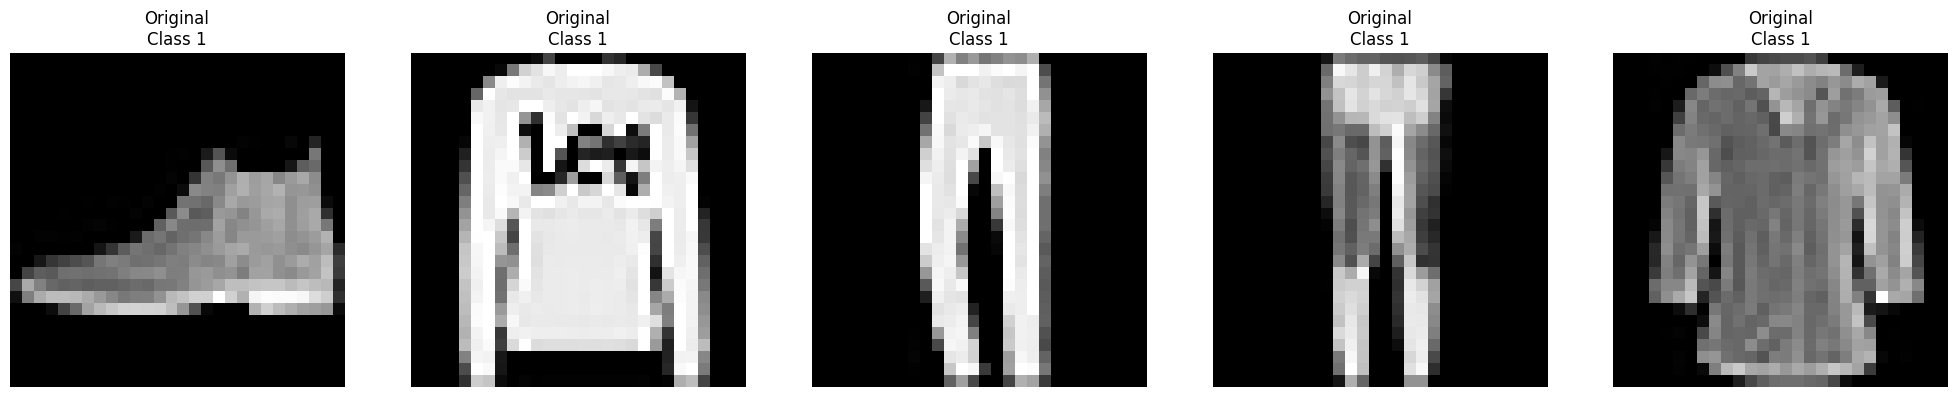

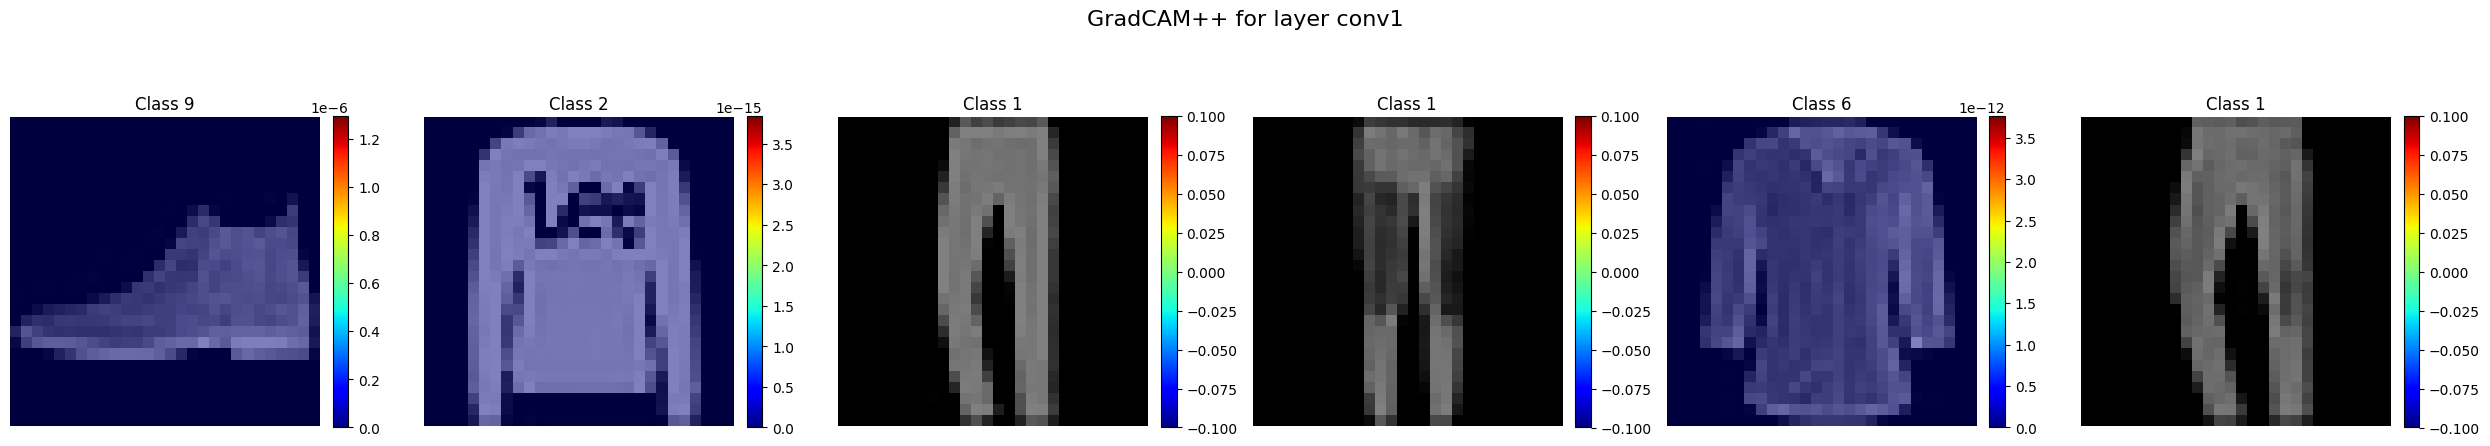

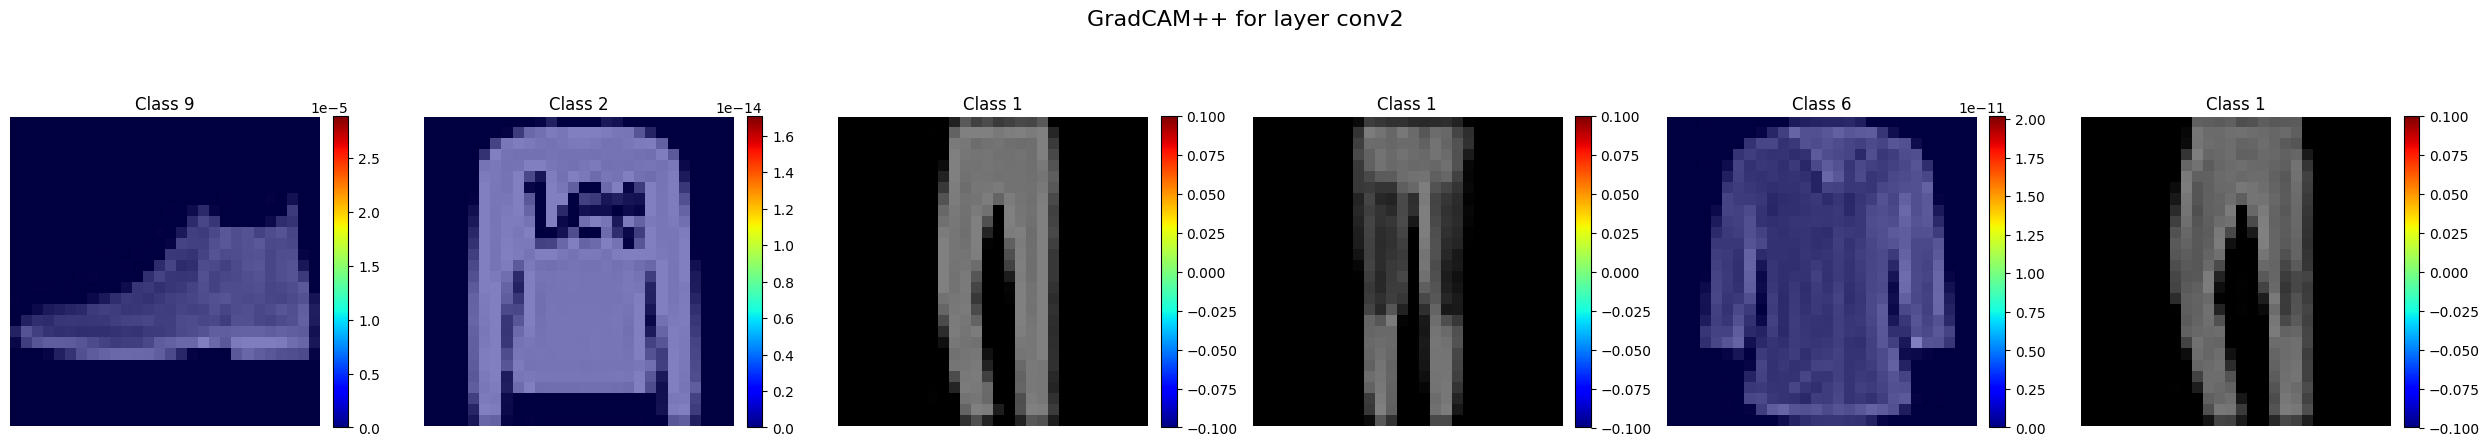

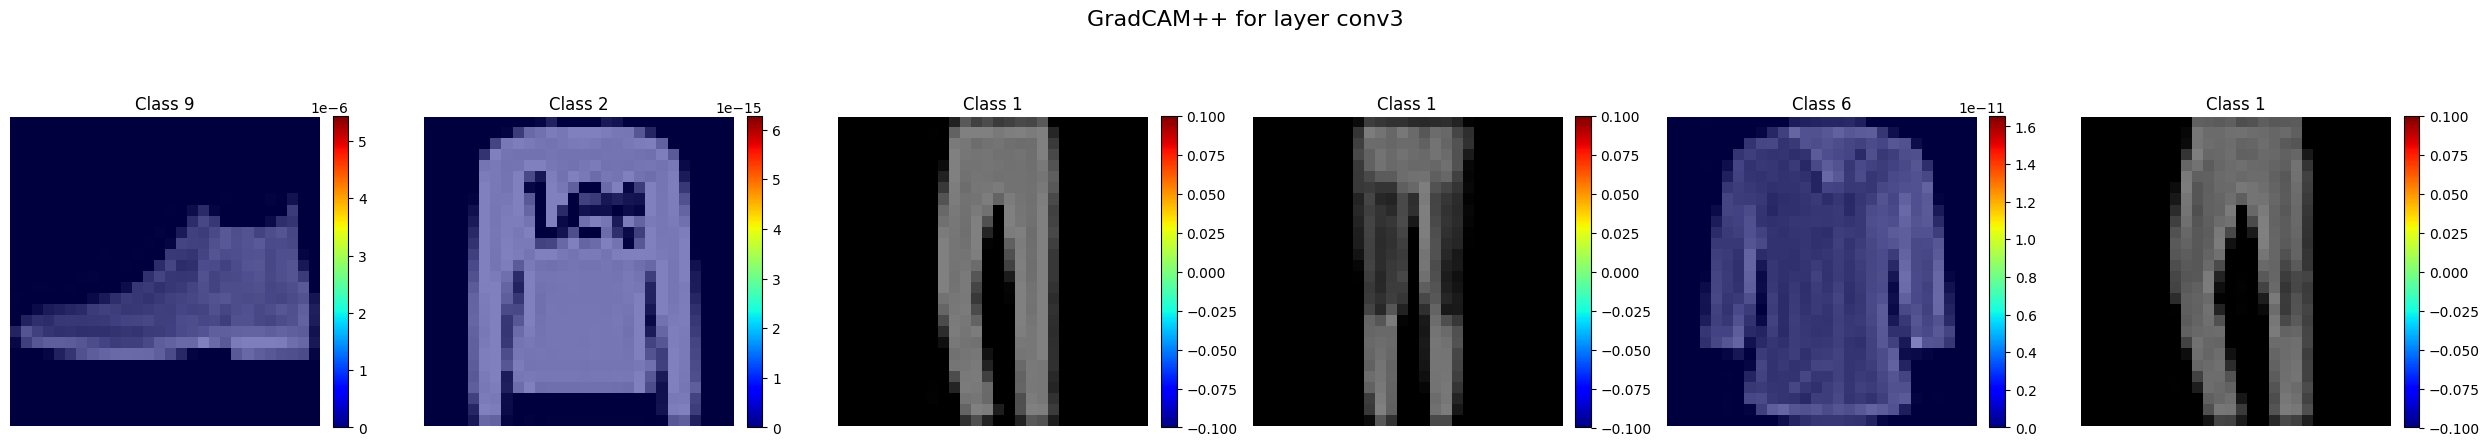

In [31]:
layers = ['conv1', 'conv2', 'conv3']

# Visualizar la imagen original con mayor tamaño
fig, axes = plt.subplots(1, 5, figsize=(25, 5))

for i in range(5):
    num_images = 5
    images = X_test[:num_images].reshape(-1, 28, 28, 1)
    image = images[i]
    ax_img = axes[i]
    ax_img.imshow(image.squeeze(), cmap='gray')
    ax_img.axis('off')
    ax_img.set_title(f'Original\nClass {label}')

for layer in layers:
    # Crear el modelo que solo tenga la salida del clasificador
    model_for_gradcam = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer('softmax_output').output)

    # Crear el objeto GradCAM++
    gradcam = GradcamPlusPlus(model_for_gradcam, model_modifier=ReplaceToLinear(), clone=True)

    # Seleccionar las primeras 6 imágenes del conjunto de prueba
    num_images = 6
    images = X_test[:num_images].reshape(-1, 28, 28, 1)
    labels = y_test[:num_images]

    # Crear una figura con subplots
    fig, axes = plt.subplots(1, 6, figsize=(25, 5))
    fig.suptitle(f'GradCAM++ for layer {layer}', fontsize=16)  # Añadir título con el nombre de la capa

    for i, (image, label) in enumerate(zip(images, labels)):
        # Generar el CAM con GradCAM++ usando la capa 'convv'
        cam = gradcam(CategoricalScore(1), image.reshape(1, 28, 28, 1), penultimate_layer=layer, normalize_cam=False)

        # Visualizar el mapa de calor superpuesto en la imagen original
        heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)
        ax_heatmap = axes[i]
        ax_heatmap.imshow(image.squeeze(), cmap='gray')
        ax_heatmap.imshow(heatmap, cmap='jet', alpha=0.5)
        ax_heatmap.axis('off')
        ax_heatmap.set_title(f'Class {label}')
        
        # Añadir la barra de colores (color bar)
        norm = plt.Normalize(vmin=cam[0].min(), vmax=cam[0].max())
        sm = plt.cm.ScalarMappable(cmap='jet', norm=norm)
        sm.set_array([])
        fig.colorbar(sm, ax=ax_heatmap, orientation="vertical", fraction=0.046, pad=0.04)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Ajustar layout para el título
    plt.show()